# Crack Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from crackest import cracks
from crackalysis import CrackAn
from crackest.crack_analyzer import CrackAnalyzer

from rosta_demonstrace import get_countours, get_crack_mask, build_graph

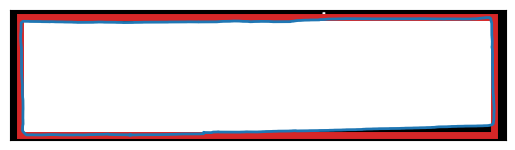

In [4]:
mask = cp.mask
r = mask[:, :] == 0
r = ~r

r = r.astype(np.uint8)

kernel = np.ones((20, 20), np.uint8)
r = cv2.erode(r, kernel)
r = cv2.dilate(r, kernel, iterations=1)

contours = measure.find_contours(r, 0.8)
centers = measure.centroid(r)
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

df = pd.DataFrame()
for contour in contours:

    c = np.expand_dims(contour.astype(np.float32), 1)
    # Convert it to UMat object
    c = cv2.UMat(c)
    area = cv2.contourArea(c)

    frame = 1
    ystart = int(contour[:, 0].min())
    if ystart > 1:
        ystart -= frame
    xstart = int(contour[:, 1].min())
    if xstart > 1:
        xstart -= frame
    yi = int(contour[:, 0].max() - ystart)
    if yi < cp.img.shape[0]:
        yi += frame
    xi = int(contour[:, 1].max() - xstart)
    if yi < cp.img.shape[1]:
        xi += frame

    dfi = pd.DataFrame(
        {
            "length": contour.shape[0],
            "contour": [contour],
            "area": area,
            "bbox": [[xstart, ystart, xi, yi]],
        },
        index=[0],
    )
    df = pd.concat([df, dfi], ignore_index=True, axis=0)

df = df.sort_values(by="length", ascending=False)
df = df.reset_index()
img_area = cp.img.shape[0] * cp.img.shape[1]
df["area_mat_ratio"] = df["area"] / df["area"].values.max()

df = df[df["area_mat_ratio"] > 0.7]

for index, row in df.iterrows():
    contour = row["contour"]
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color="tab:blue")
    bbox = row["bbox"]

    imgr = cp.img[bbox[1] : bbox[3] + bbox[1], bbox[0] : bbox[2] + bbox[0], :]
    maskr = cp.mask[bbox[1] : bbox[3] + bbox[1], bbox[0] : bbox[2] + bbox[0]]

    ax.add_patch(
        Rectangle(
            (bbox[0], bbox[1]),
            bbox[2],
            bbox[3],
            facecolor="none",
            edgecolor="tab:red",
            lw=5,
        )
    )


ax.axis("image")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

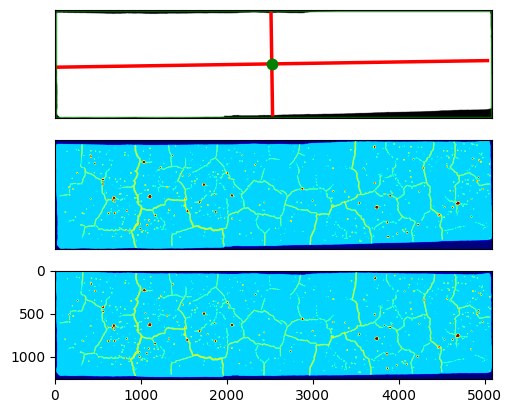

In [17]:
reg_props = (
    "area",
    "centroid",
    "orientation",
    "axis_major_length",
    "axis_minor_length",
    "bbox",
)

length = 160
width = 40


mask = maskr
bw_mask = mask[:, :] == 0
bw_mask = ~bw_mask

image = bw_mask.astype(np.uint8)
label_img = label(image)
# regions = regionprops(label_img)

props_mat = regionprops_table(label_img, properties=reg_props)
dfmat = pd.DataFrame(props_mat)
dfmat.sort_values(by=["area"], ascending=True)
dfmat = dfmat.reset_index()

# %
fig, (ax, ax1, ax3) = plt.subplots(nrows=3, ncols=1)
ax.imshow(image, cmap=plt.cm.gray)
#
dfii = pd.DataFrame()
for index, props in dfmat.iterrows():
    # y0, x0 = props.centroid-0
    if props["area"] > 1000:
        y0 = props["centroid-0"]
        x0 = props["centroid-1"]

        orientation = props["orientation"]

        rat1 = 0.43
        x0i = x0 - math.cos(orientation) * rat1 * props["axis_minor_length"]
        y0i = y0 + math.sin(orientation) * rat1 * props["axis_minor_length"]

        x1 = x0 + math.cos(orientation) * rat1 * props["axis_minor_length"]
        y1 = y0 - math.sin(orientation) * rat1 * props["axis_minor_length"]

        rat2 = 0.43
        x2i = x0 + math.sin(orientation) * rat2 * props["axis_major_length"]
        y2i = y0 + math.cos(orientation) * rat2 * props["axis_major_length"]

        x2 = x0 - math.sin(orientation) * rat2 * props["axis_major_length"]
        y2 = y0 - math.cos(orientation) * rat2 * props["axis_major_length"]

        ax.plot((x0i, x1), (y0i, y1), "-r", linewidth=2.5)

        he = {"alpha": (y0i - y1) / (x0i - x1)}
        he["beta"] = y1 - he["alpha"] * x1
        he["len"] = props["axis_minor_length"]
        he["label"] = "width"

        ax.plot((x2i, x2), (y2i, y2), "-r", linewidth=2.5)

        ve = {"alpha": (y2i - y2) / (x2i - x2)}
        ve["beta"] = y2 - ve["alpha"] * x2
        ve["len"] = props["axis_major_length"]
        ve["label"] = "length"

        ax.plot(x0, y0, ".g", markersize=15)

        minr = int(props["bbox-0"])
        minc = int(props["bbox-1"])
        maxr = int(props["bbox-2"])
        maxc = int(props["bbox-3"])

        dfii = pd.concat(
            [
                dfii,
                pd.DataFrame(
                    {"bbox": [[minr, minc, maxr, maxc]], "area": props["area"]}
                ),
            ],
            ignore_index=True,
            axis=0,
        )
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax.plot(bx, by, "-g", linewidth=2.5, alpha=0.7)

        rows, cols, channels = imgr.shape

        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), orientation / 2, 1)
        img_r = cv2.warpAffine(imgr, M, (cols, rows))
        mask_r = cv2.warpAffine(maskr, M, (cols, rows))

        # img_r=rotate(cp.img[minr:maxr,minc:maxc,:], orientation)
        # mask_r=rotate(cp.mask[minr:maxr,minc:maxc], orientation)

    # break

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ax1.imshow(imgr)
ax1.imshow(mask, alpha=1, cmap="jet")
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])


# imgrt=img_r.reshape((img_r.shape[0],img_r.shape[1],3),255).astype(np.uint8)

# mask_r=cp.GetMask(img=img_r)
mask_r = mask_r
mask_r = mask_r.round(0)

ax3.imshow(img_r)
ax3.imshow(mask_r, cmap="jet", alpha=1)

plt.show()

In [ ]:
reg_props = (
    "area",
    "centroid",
    "orientation",
    "axis_major_length",
    "axis_minor_length",
    "bbox",
)

length = 160
width = 40

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
# MeasureNodes(img_r,mask_r,ax) # def MeasureNodes(img,mask,ax):

eq = get_equations(mask_r)

# Filter only cracks mask
crack_bw = mask_r[:, :] == 2
crack_bw = crack_bw.astype(np.uint8)

# Determine the distance transform.
skel = skeletonize(crack_bw, method="lee")

# build graph from skeleton
graph = sknw.build_sknw(skel, multi=False)

# draw image
ax.imshow(img_r, cmap="gray")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.imshow(img_r, cmap="gray")
SHOW_ALL = False

# draw edges by pts
m_nodes = pd.DataFrame()
for s, e in graph.edges():
    ps = graph[s][e]["pts"]
    if ps.shape[0] > 20:
        idxx = [0, ps.shape[0] - 1]
        idxy = [0, 0]
        idxyi = [1, 1]

        yps = ps[idxx, idxy]
        xps = ps[idxx, idxyi]
        m_nodesi = pd.DataFrame({"x": xps, "y": yps}, index=[0, 1])
        m_nodes = pd.concat([m_nodes, m_nodesi], ignore_index=True)

        ax.scatter(xps, yps, color="red")
        ax.plot(ps[:, 1], ps[:, 0], "green")


if SHOW_ALL:
    m_node_freq = m_nodes[["x", "y"]].value_counts().reset_index(name="count")
    
    
    nodes_in = m_node_freq[m_node_freq["count"] > 1]
    
    ax.scatter(nodes_in["x"].values, nodes_in["y"].values, color="lime", s=120)
    
    
    skew_x = skew(nodes_in["x"])
    skew_y = skew(nodes_in["y"])
    
    kurt_x = kurtosis(nodes_in["x"])
    kurt_y = kurtosis(nodes_in["y"])
    
    
    hx = np.linspace(0, img_r.shape[1], 100)
    hy = hx * eq["v"]["alpha"] + eq["v"]["beta"]
    
    vy = np.linspace(0, img_r.shape[0], 100)
    vx = (vy - eq["h"]["beta"]) / eq["h"]["alpha"]
    
    ax.plot(hx, hy, "-", color="tab:red")
    ax.plot(vx, vy, "-", color="tab:red")
    
    hx = np.array([0, img_r.shape[1]])
    hy = hx * eq["v"]["alpha"] + eq["v"]["beta"]
    
    vy = np.array([0, img_r.shape[0]])
    vx = (vy - eq["h"]["beta"]) / eq["h"]["alpha"]
    
    
    norm = np.linalg.norm
    
    ph1 = np.array([hx[0], hy[0]])  # point 1
    ph2 = np.array([hx[1], hy[1]])  # point 2
    
    pv1 = np.array([vx[0], vy[0]])  # point 1
    pv2 = np.array([vx[1], vy[1]])  # point 2
    
    
    dfh = pd.DataFrame()
    for index, row in nodes_in.iterrows():
        p3 = row[["x", "y"]].to_numpy()
    
        dfhi = pd.DataFrame(
            {
                "dist_h": get_distance(ph1, ph2, p3),
                "dist_v": get_distance(pv1, pv2, p3),
            },
            index=[0],
        )
        dfh = pd.concat([dfh, dfhi], ignore_index=True, axis=0)
    
    nodes_all = pd.concat([nodes_in, dfh], axis=1, ignore_index=True)
    if nodes_all.shape[0] > 0:
        nodes_all.columns = ("x", "y", "count", "dist_h", "dist_v")
    
        mean_h = nodes_all["dist_h"].values.mean()
        mean_v = nodes_all["dist_v"].values.mean()
    
        mean_h_r = mean_h / eq["h"]["len"]
        mean_v_r = mean_v / eq["v"]["len"]
    
        if mean_v_r > mean_h_r:
            mean_node_r = mean_h_r / mean_v_r
            typ_crack = "Longitudinal"
        else:
            mean_node_r = mean_v_r / mean_h_r
            typ_crack = "Transverse"
    
    else:
        mean_node_r = 0
        typ_crack = "No nodes"
    
        # Intersection of both lines
    xin = (eq["h"]["beta"] - eq["v"]["beta"]) / (
        eq["v"]["alpha"] - eq["h"]["alpha"]
    )
    yin = xin * eq["h"]["alpha"] + eq["h"]["beta"]
    
    ax.scatter(xin, yin, color="tab:red", s=400)
ax.set_xlim([0, img_r.shape[1]])
ax.set_ylim([0, img_r.shape[0]])
ax.axis("off")
plt.legend()
if SHOW_ALL:
    ax.set_title(
        "[x,y] Skew: ({:.2f},{:.2f}); Kurt: ({:.2f},{:.2f}) nodes: {:d} node_dist: {:.2f} type: {:s}".format(
            skew_x,
            skew_y,
            kurt_x,
            kurt_y,
            nodes_in.shape[0],
            mean_node_r,
            typ_crack,
        )
    )
plt.show()

In [4]:
cp = cracks.CrackPy(model=0)
ca = CrackAn(cp)
ca.Input(file=r"../Examples/Img/ID14_940_Image.png")
ca.Registr()

,bbox,sbbox,angle,area,x0,y0,subspec,eq,sett,ratio,cover
0,"[23, 123, 1338, 5213]","[105, 1340, 11, 5079]",0.880573,6030595.0,2637.345705,714.198233,"{'img': [[[0 0 0], [0 0 0], [0 0 0], [0 0 0], ...","{'h': {'alpha': 65.06136587085096, 'beta': -17...","{'ID': 1, 'angle': -0.8805727874259759, 'label...",0,1.0


In [7]:
imgr, maskr = get_countours(cp, plot=False)
mask_r, img_r = get_crack_mask(imgr, maskr, plot=False)
# plot_specimen(img_r)
graph, eq = build_graph(mask_r)
# plot_cracks(True, eq)
# plot_cracks()

In [8]:
cran = CrackAnalyzer(graph)
# cran.graph_stats()
df_nodes, df_edges = cran.analyze_cracks()

In [15]:
print(f"Average number of edges per node: {df_nodes['num_edges'].mean():.3f}")
print(f"Total length of cracks: {df_edges['length'].sum():.3f}")
mean_angle_weighted = (df_edges["angle"] * df_edges["length"]).sum() / df_edges["length"].sum()
print(f"Average direction of cracks: {mean_angle_weighted:.3f}°")

Average number of edges per node: 1.350
Total length of cracks: 23549.719
Average direction of cracks: 90.089°


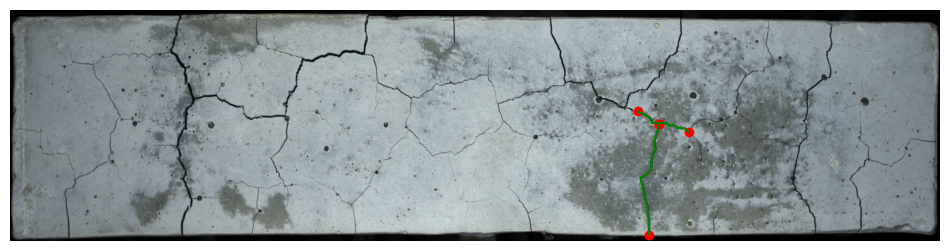

In [451]:
# cran.plot_cracks(img_r)
cran.plot_cracks(img_r, selected_edge_ids=["2_1374", "1243_1374", "1374_1512"])
# cran.plot_cracks(img_r, selected_edge_ids=["2557_2557"])  # -> circular crack???

In [440]:
img_r.shape

(1265, 5091, 3)

In [441]:
df_nodes.loc[2], df_nodes.loc[1374]
# df_nodes.loc[2557]  # -> circular crack???

(coordinates          [34, 3499]
 num_edges                     1
 neighboring_nodes        [1374]
 Name: 2, dtype: object,
 coordinates              [643, 3554]
 num_edges                          3
 neighboring_nodes    [2, 1243, 1512]
 Name: 1374, dtype: object)

In [442]:
# df_edges[df_edges["angle"] < 0.0]
df_edges.loc[["2_1374", "1243_1374", "1374_1512"]]
# df_edges.loc[["2557_2557"]]  # -> circular crack???

,num_pts,start_node,end_node,length,angle
edge_id,,,,,
2_1374,626,2,1374,688.374675,84.302602
1243_1374,165,1243,1374,190.509668,150.326931
1374_1512,130,1374,1512,151.367532,148.131751


In [424]:
df_edges.describe()

,num_pts,start_node,end_node,length,angle
count,234.000000,234.000000,234.000000,234.000000,234.000000
mean,88.649573,1360.978632,1489.239316,100.639826,90.565514
std,97.690702,748.844589,723.991774,110.965345,39.634583
min,21.000000,0.000000,57.000000,21.656854,6.110842
25%,28.000000,753.000000,879.250000,31.692388,70.766956
50%,48.500000,1425.500000,1506.000000,55.624131,90.000000
75%,117.000000,1945.250000,2075.000000,133.031746,114.822533
max,720.000000,2584.000000,2584.000000,821.310750,172.205053


In [452]:
df_nodes.describe()

,num_edges
count,371.000000
mean,1.350404
std,0.771883
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,4.000000
